In [ ]:
import sys
import numpy as np
import h5py as h5
from itertools import permutations
import itertools
import collections
import hashlib
from numpy.random import Generator, SeedSequence, PCG64
import matplotlib.pyplot as plt
import scipy.constants as const

User Input

In [11]:
# chose whether to fit spin singlet (pp_SING) or triplet (pn_TRIP) data
# the deutron is in the TRIP channel
#c_name  = 'pp_SING'
c_name  = 'pn_TRIP'
Nbs     = 1000
bs_seed = 'c103'
NL      = 48
M_N     = 0.70279 # determined in our correlator fits
HBARC   = const.hbar * const.c / const.e * 1e15 / 1e6
a_fm    = 0.08636 # see table 3 of https://arxiv.org/abs/1608.08900
scale   = HBARC / a_fm

Bootstrap Utilities

In [19]:
def get_rng(seed: str, verbose=False):
    """Generate a random number generator based on a seed string."""
    # Over python iteration the traditional hash was changed. So, here we fix it to md5
    hash = hashlib.md5(seed.encode("utf-8")).hexdigest()  # Convert string to a hash
    seed_int = int(hash, 16) % (10 ** 6)  # Convert hash to an fixed size integer
    if verbose:
        print("Seed to md5 hash:", seed, "->", hash, "->", seed_int)
    # Create instance of random number generator explicitly to ensure long time support
    # PCG64 -> https://www.pcg-random.org/
    # see https://numpy.org/doc/stable/reference/random/generated/numpy.random.seed.html
    rng = Generator(PCG64(SeedSequence(seed_int)))
    return rng

def make_bs_list(Ndata, Nbs, Mbs=None, seed=None, verbose=False):
    if Mbs:
        m_bs = Mbs
    else:
        m_bs = Ndata

    # seed the random number generator
    rng = get_rng(seed,verbose=verbose) if seed else np.random.default_rng()

    # make BS list: [low, high)
    bs_list = rng.integers(low=0, high=Ndata, size=[Nbs, m_bs])

    return bs_list

def make_bs_corr(corr, Nbs, Mbs=None, seed=None, verbose=False):
    Ndata = corr.shape[0]
    bs_list = make_bs_list(Ndata, Nbs, Mbs=Mbs, seed=seed, verbose=verbose)
    #print(bs_list[0,0:5])
    corr_bs = []
    corr_bs.append(corr.mean(axis=0))
    for bs in range(len(bs_list)):
        corr_bs.append(corr[bs_list[bs]].mean(axis=0))
    return np.array(corr_bs)

In [ ]:
# load the NN data.  The NEG PAR data has already been time-reversed so can be directly 
# averaged with the POS PAR data
with h5.File('c103_nn_%s_hal_nblock_15.h5' %(c_name),'r') as f5:
    nn_data = 0.5 * f5[c_name][()][:,:,:,:,:,0]
with h5.File('c103_nn_%s_NEG_PAR_hal_nblock_15.h5' %(c_name),'r') as f5:
    nn_data += 0.5 * f5['%s_NEG_PAR' %(c_name)][()][:,:,:,:,:,0]
print(nn_data.shape)

(99, 32, 48, 48, 48)


In [ ]:
# load the single nucleon data
with h5.File('c103_n_nblock_15.h5','r') as f5:
    prot = f5['proton'][()][:,:,0]
print(prot.shape)

(99, 32)


In [ ]:
def A1_project_corr(corr):
    ''' perform symmetry transformations on data that respect A1g symmetry
        shape of corr:
            [Ncfg, Nt, PZ, PY, PX]

        first, perform all momentum flip transformations that preserve only
        even "parity" modes.  The data in momentum space is stored (in units of 2pi/L) as
            [0, 1, 2, ..., L/2-1, L/2, -L/2+1, ..., -2, -1]
        and therefore
            np.roll(corr,-1,2)[:,:,::-1,:,:] changes NN(p_z) -> NN(-p_z)
            np.roll([p0, p1, p2, ..., pL/2-1, pL/2, -pL/2+1, ..., -p2, -p1], -1) 
                -> [p1, p2, ..., pL/2-1, pL/2, -pL/2+1, ..., -p2, -p1, p0]

        Therefore, applying the np.roll(corr, -1,axis=i) and then flipping the direction, ::-1, leads to
            [p0,  p1,  p2, ...,  pL/2-1, pL/2, -pL/2+1, ..., -p2, -p1]
           +[p0, -p1, -p2, ..., -pL/2+1, pL/2,  pL/2-1, ...,  p2,  p1]
    '''
    wave_tmp1 = (corr[:,:,:,:,:] 
                 + np.roll(corr,-1,2)[:,:,::-1,:,:]
                 + np.roll(corr,-1,3)[:,:,:,::-1,:]
                 + np.roll(corr,-1,4)[:,:,:,:,::-1]
                 + np.roll(np.roll(corr,-1,2),-1,3)[:,:,::-1,::-1,:]
                 + np.roll(np.roll(corr,-1,3),-1,4)[:,:,:,::-1,::-1]
                 + np.roll(np.roll(corr,-1,4),-1,2)[:,:,::-1,:,::-1]
                 + np.roll(np.roll(np.roll(corr,-1,2),-1,3),-1,4)[:,:,::-1,::-1,::-1]
                )/8.0
    ''' second, perform all axis-swap transformations that respect the A1 symmetry
    '''
    wave_tmp2 = (wave_tmp1 
                 + np.swapaxes(wave_tmp1,2,3)
                 + np.swapaxes(wave_tmp1,3,4)
                 + np.swapaxes(wave_tmp1,4,2)
                 + np.swapaxes(np.swapaxes(wave_tmp1,2,3),3,4)
                 + np.swapaxes(np.swapaxes(wave_tmp1,2,4),4,3)
                )/6.0
    return wave_tmp2

In [23]:
# A1 project in momentum space, then FFT to XYZ space
nn_data_A1 = np.fft.fftn(A1_project_corr(nn_data), axes=(2,3,4))

# clear memory
del nn_data
print(nn_data_A1.shape)

(99, 32, 48, 48, 48)


The HAL QCD potential is given by
\begin{equation}
V(r) = \frac{1}{M_n} \frac{\nabla^2 R}{R} - \frac{(\partial/\partial t)R}{R}
+ \frac{1}{4M_n} \frac{(\partial^2/\partial t^2) R}{R}\, ,
\end{equation}
where
\begin{equation}
R(t,r) = \frac{C_{NN}(t,r)}{N(t)^2}\, .
\end{equation}
As the denominator does not have any dependence upon $r$, we can apply the Laplacian to the two-nucleon correlation function, prior to forming the ratio correlator.

In [ ]:
def get_inequivalent_directions( Ns):
    ''' collect all inequivalent choices under A1_projection
        Ns = number of max sites in any one direction

        if Ns is 3, then we will collect tuples in out: a length paired with a 3-vec
            (0,       (0,0,0)), 
            (1,       (0,0,1)), 
            (sqrt( 2),(0,1,1)), 
            (sqrt( 3),(1,1,1)), 
            (2,       (0,0,2)), 
            (sqrt( 5),(0,1,2)), 
            (sqrt( 6),(1,1,2)), 
            (sqrt( 8),(0,2,2)),
            (3,       (1,2,2)), 
            (sqrt(12),(2,2,2))
        The vectors are constrained to z <= y <= x < Nx.
        note, this treats vectors of different length but different elements of A1 as different
        eg. (0,0,3) and (1,2,2)
    '''
    out = []
    for x0 in range( Ns):
        for y0 in range( x0+1):
            for z0 in range( y0+1):
                vec = np.array([ z0, y0, x0])
                out.append(( np.linalg.norm( vec), tuple( vec)))
    dir_norm, dir_vec = tuple( zip( *sorted( out)))            ## sort by norm first, then vector
    dir_vec_idx = tuple( np.array( x) for x in zip( *dir_vec)) ## reformat so they can be used as a slice
    return dir_norm, dir_vec_idx

# This function is unused in this notebook
def get_equivalent_directions( Ns):
    ## get a set of directions that are equivalent to each other under A1_projection
    dir_norm, dir_vec_idx = get_inequivalent_directions( Ns)
    dir_vec = list( zip( *dir_vec_idx)) ## restore to 3vectors
    ## create equivalent choices
    dvec_perm = tuple(
        (dnorm, dvec, tuple( np.array( x) for x in zip( *tuple( permutations_and_signs( dvec)))))
        for dnorm, dvec in zip( dir_norm, dir_vec) )
    return tuple( zip( *dvec_perm))    

# This function is unused in this notebook
def permutations_and_signs( dvec):
    ## from a given vector, find all choices that are equivalent under A1_projection
    # Actually, what this does is take a 3-vec and apply all parity
    # and direction exchanges to it.    
    # What it does not do is remove duplicates.   For example, if dvec=(1,1,1),
    # then parity has an effect, but exchanges do not, so we generate 6*8k entries
    out = []
    for x0s in [-1,1]:
        for x1s in [-1,1]:
            for x2s in [-1,1]:
                svec = np.array([x0s,x1s,x2s])
                out.extend([ svec *dperm for dperm in permutations( dvec) ])
    return out


In [ ]:
def laplacian(c_nn, type='single-axis-improved'):
    # c_nn[cfg, t, x, y, z]
    if type=='7 point laplacian':
        nabla_nn  = -6.0 * c_nn
        nabla_nn += np.roll(c_nn, -1, 2)  # (array,dist,whichdim)
        nabla_nn += np.roll(c_nn, +1, 2)
        nabla_nn += np.roll(c_nn, -1, 3)
        nabla_nn += np.roll(c_nn, +1, 3)
        nabla_nn += np.roll(c_nn, -1, 4)
        nabla_nn += np.roll(c_nn, +1, 4)

    elif type=='single-axis-improved':
        nabla_nn  = -7.5 * c_nn
        nabla_nn += np.roll(c_nn, -1, 2)*4/3
        nabla_nn += np.roll(c_nn, +1, 2)*4/3
        nabla_nn += np.roll(c_nn, -1, 3)*4/3
        nabla_nn += np.roll(c_nn, +1, 3)*4/3
        nabla_nn += np.roll(c_nn, -1, 4)*4/3
        nabla_nn += np.roll(c_nn, +1, 4)*4/3
        nabla_nn -= np.roll(c_nn, -2, 2)*1/12
        nabla_nn -= np.roll(c_nn, +2, 2)*1/12
        nabla_nn -= np.roll(c_nn, -2, 3)*1/12
        nabla_nn -= np.roll(c_nn, +2, 3)*1/12
        nabla_nn -= np.roll(c_nn, -2, 4)*1/12
        nabla_nn -= np.roll(c_nn, +2, 4)*1/12
    # we could implement the 27-point stencil that takes
    # contributions along diagonals
    #    np.roll(np.roll(c_nn,-1,2), -1, 3)
    # which have better rotational symmetry.
    # However, we found no significant difference between the simple 7-point
    # and the single-axis-improved, so we stopped there
    else:
        print('your laplacian type is not implemented')
        sys.exit()

    return nabla_nn

In [12]:
# NL = 48 is the number of sites in each direction
r_norm, r_vec = get_inequivalent_directions(NL)
# cut off our radius at NL/2
r_stop = next(i for i,v in enumerate(r_norm) if v > NL//2)
print(r_stop, r_norm[r_stop])

1493 24.020824298928627


In [27]:
duplicate_r = [item for item, count in collections.Counter(r_norm[:r_stop+1]).items() if count > 1]
print(len(duplicate_r))

400


In [28]:
laplacian_nn = laplacian(nn_data_A1)  # computed for all time slices
tmp_NN  = np.zeros([nn_data_A1.shape[0], nn_data_A1.shape[1], len(r_norm)])
tmp_lap = np.zeros([nn_data_A1.shape[0], nn_data_A1.shape[1], len(r_norm)])
# nn_data_A1[cfg, ti, xi, yi, zi]
for c in range(nn_data_A1.shape[0]): # configurations
    for t in range(nn_data_A1.shape[1]):
        # tables indexed by the r_vec index (r_vec is a table of inequiv 3-vecs)
        tmp_NN[c,t]  = nn_data_A1[c,t][r_vec].real
        tmp_lap[c,t] = laplacian_nn[c,t][r_vec].real
print(tmp_NN.shape)

# clear memory
del laplacian_nn

(99, 32, 19600)


In [ ]:
# map data to function of "r"
# We've projected to A1, which means averaging over all
# direction swaps and parity transforms.   Therefore all octants
# should match and we can pick distance r values from our list.
# There can be multiple vectors with the same r. 
r_unique = []
NN_unique = []
lap_NN_unique = []
for i_r,r in enumerate(r_norm[:r_stop+1]):  # 3-vec index and length
    if r not in r_unique:
        r_unique.append(r)  
        # duplicate_r is a list of r values that appear more than once in our list
        if r not in duplicate_r:
            NN_unique.append(tmp_NN[:,:,i_r])
            lap_NN_unique.append(tmp_lap[:,:,i_r])
        else:
            ''' This performs a equal weight average of vectors of the same length
                but that do not transform into each other under A1g
                eg. (0,0,3) and (1,2,2)
                Perhaps a weighted average should be performed counting all equivalent
                vectors, e.g. there are 
                    -  6 equal length permutations of (0,0,n)
                    - 12 equal length permutations of (0,n,n)
                    - 24 equal length permutations of (0,n,m)
                    - 24 equal length permutations of (n,m,m)
                    - 48 equal length permutations of (n,m,p)
                so with |n| = 3, we would have a weighted average of
                    (6 * data[0,0,3] + 24 * data[1,2,2] ) / 30
            '''
            r_vals = [i for i, j in enumerate(r_norm) if j == r]
            NN_unique.append(tmp_NN[:,:,r_vals].mean(axis=2))
            lap_NN_unique.append(tmp_lap[:,:,r_vals].mean(axis=2))
r_unique = np.array(r_unique)
NN_unique = np.einsum('ijk->jki', np.array(NN_unique))
lap_NN_unique = np.einsum('ijk->jki', np.array(lap_NN_unique))
print(len(r_unique))
print(NN_unique.shape)

483
(99, 32, 483)


In [30]:
NN_bs  = make_bs_corr(NN_unique,     Nbs, seed=bs_seed)
N_bs   = make_bs_corr(prot,          Nbs, seed=bs_seed)
lap_bs = make_bs_corr(lap_NN_unique, Nbs, seed=bs_seed)

In [ ]:
# Temporal derivative 
R_bs     = NN_bs / N_bs[:,:, np.newaxis]**2
R_bs_p1  = np.roll(R_bs, -1, axis=1)
R_bs_m1  = np.roll(R_bs,  1, axis=1)
R_bs_p2  = np.roll(R_bs, -2, axis=1)
R_bs_m2  = np.roll(R_bs,  2, axis=1)

V0_bs    = lap_bs / NN_bs / M_N
V1_bs    = -(R_bs_p1 - R_bs_m1) / 2 / R_bs
V2_bs    = (R_bs_p1 - 2.0*R_bs + R_bs_m1) / R_bs /(4.0*M_N)
V3_bs    = (R_bs_p2 - R_bs_m2) / R_bs 
V4_bs    = ((4/3)*(R_bs_p1 + R_bs_m1)-(1/12)*(R_bs_p2+R_bs_m2)-(15/6)*R_bs) / R_bs /(4.0*M_N)

# leading order
#V_HAL_bs = V0_bs + V1_bs + V2_bs

# improved temporal derivative
V_HAL_bs = V0_bs + (4/3)* V1_bs + V4_bs + (1/12)*V3_bs
print(V_HAL_bs.shape)

(1001, 32, 483)


In [32]:
with h5.File('c103_V_hal_%s.h5' %(c_name),'w') as f5:
    f5.create_dataset('V_hal_%s' %(c_name), data=V_HAL_bs)
    f5.create_dataset('r_a',                data=r_unique)
    f5.create_dataset('V0_%s' %(c_name),    data=V0_bs)
    f5.create_dataset('Vdt_%s' %(c_name),   data=V1_bs)
    f5.create_dataset('Vdtdt_%s' %(c_name), data=V2_bs)
    f5.create_dataset('R_%s' %(c_name),     data=R_bs)

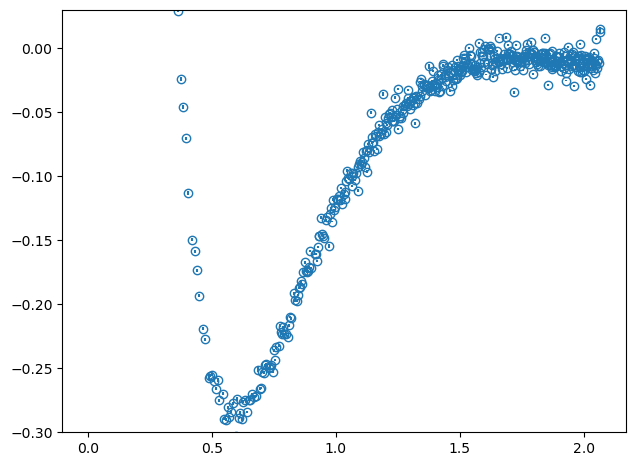

In [33]:
plt.figure()
ax = plt.axes([.1,.1,.88,.88])
tplt = 13
y  = [np.mean([V_HAL_bs[c,tplt][i]/a_fm for c in range(Nbs)]) for i in range(len(r_unique))]
dy = [np.std([V_HAL_bs[c,tplt][i] for c in range(Nbs)]) for i in range(len(r_unique))]#V_HAL_bs[1:].std(axis=0)[5]
ax.errorbar([np.linalg.norm(i)* 0.086 for i in r_unique], y, yerr=dy, linestyle='None', marker='o', mfc='None');
ax.set_ylim(-0.3, 0.03);